In [1]:
!pip install albumentations opendatasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 20.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 54.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.9/423.9 kB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 129.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.0/163.0 kB 42.2 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105789 sha256=0443eae647209a3ceed6b6cd4982a9bdd40e4b4ae2d49e8061413e4cf084cd67
  Stored in directory: /root/.cache/pip/wheels/ff/55/fb/b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle
  Attempting uninstall: certifi
    Found existing installation: certifi 2020.6.20
    Uninstalling c

In [5]:
import pandas as pd
import opendatasets as od
import timm

In [6]:
od.download('https://www.kaggle.com/datasets/bulbazavril/glamurblond')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  bulbazavril


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/bulbazavril/glamurblond


100%|██████████| 752M/752M [00:08<00:00, 92.2MB/s] 


In [8]:
def change_time(x):
    hour, minutes, seconds = x.split(':')
    return int(hour) * 3600 + int(minutes) * 60 + int(seconds)

df = pd.read_excel('glamurblond/1 .xlsx')
df['time'] = df['time'].apply(change_time)

s = {x: y for x,y in zip(df['time'], df['action'])}
max_value = df['time'].max()

In [9]:
import cv2

video_path = 'glamurblond/_.mp4'
cap = cv2.VideoCapture(video_path)
    
video_fps = cap.get(cv2.CAP_PROP_FPS)
frame_interval = int(video_fps / 1)

current_frame = 0
extracted_frames = 0

frames = []
labels = []
cur_pos = -1
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Если текущий кадр кратен интервалу, сохраняем его
    if current_frame % frame_interval == 0:
        frame_num = current_frame / frame_interval

        if frame_num > max_value:
            break
        else:

            if cur_pos == -1 and frame_num not in s:
                current_frame += 1
                continue
            
            if frame_num in s:
                cur_pos = s[frame_num]


            labels.append(cur_pos) 
            frames.append(frame)

        extracted_frames += 1

        print(frame_num / max_value)
    
    current_frame += 1

cap.release()

0.20226757369614512
0.20272108843537415
0.20317460317460317
0.2036281179138322
0.20408163265306123
0.20453514739229026
0.20498866213151928
0.2054421768707483
0.2058956916099773
0.20634920634920634
0.20680272108843537
0.2072562358276644
0.20770975056689342
0.20816326530612245
0.20861678004535147
0.2090702947845805
0.20952380952380953
0.20997732426303856
0.21043083900226758
0.2108843537414966
0.2113378684807256
0.21179138321995464
0.21224489795918366
0.2126984126984127
0.21315192743764172
0.21360544217687075
0.21405895691609977
0.2145124716553288
0.21496598639455783
0.21541950113378686
0.21587301587301588
0.2163265306122449
0.2167800453514739
0.21723356009070294
0.21768707482993196
0.218140589569161
0.21859410430839002
0.21904761904761905
0.21950113378684807
0.2199546485260771
0.22040816326530613
0.22086167800453516
0.22131519274376418
0.2217687074829932
0.2222222222222222
0.22267573696145124
0.22312925170068026
0.2235827664399093
0.22403628117913832
0.22448979591836735
0.224943310657596

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import albumentations as albu
from albumentations.pytorch import ToTensorV2

DEVICE = torch.device('mps')

# Custom dataset class for loading video frames
class VideoDataset(Dataset):
    def __init__(self, frames, labels, video_len=5, transform=None):
        self.frames = frames
        self.labels = labels
        self.transform = transform
        self.video_len = video_len

    def __len__(self):
        return len(self.frames) - self.video_len

    def __getitem__(self, idx):
        video = [self.frames[idx + i] for i in range(self.video_len)]
        label = self.labels[idx + self.video_len - 1]
        if self.transform:
            # print(self.transform, video[0])
            video = [self.transform(image=frame)['image'] for frame in video]
        video = torch.stack(video)
        return video, torch.tensor(label)

transform = albu.Compose([
    albu.Resize(384, 384),
    albu.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [11]:
new_frames = [frames[i] for i in range(len(frames)) if i % 1 == 0]
new_labels = [labels[i] for i in range(len(frames)) if i % 1 == 0]

test_size = 0.3


train_frames = new_frames[:int(len(new_frames) * (1 - test_size))]
train_labels = new_labels[:int(len(new_labels) * (1 - test_size))]
val_frames = new_frames[int(len(new_frames) * (1 - test_size)):]
val_labels = new_labels[int(len(new_labels) * (1 - test_size)):]

train_ds = VideoDataset(train_frames, train_labels, transform=transform)
valid_ds = VideoDataset(train_frames, train_labels, transform=transform)

train_dataloader = DataLoader(train_ds, batch_size=16)
valid_dataloader = DataLoader(valid_ds, batch_size=16)

In [12]:
# Define the CNN-LSTM model
class CNN_LSTM(nn.Module):
    def __init__(self, cnn_model, hidden_dim, lstm_layers, num_classes):
        super(CNN_LSTM, self).__init__()
        self.cnn = cnn_model
        self.lstm = nn.LSTM(input_size=1024, 
                            hidden_size=hidden_dim, 
                            num_layers=lstm_layers, 
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, lstm_input=None):
        batch_size, seq_len, C, H, W = x.size()
        c_in = x.view(batch_size * seq_len, C, H, W)  # Flatten to [batch_size*seq_len, C, H, W]
        c_out = self.cnn(c_in)  # Pass through the CNN
        c_out = c_out.view(batch_size, seq_len, -1)  # Reshape to [batch_size, seq_len, feature_dim]

        if lstm_input is None:
            lstm_out, hidden_lstm = self.lstm(c_out)  # LSTM output
        else:
            lstm_out, hidden_lstm = self.lstm(c_out, (lstm_input[0][:,-1:,:], lstm_input[1][:,-1:,:]))

        # lstm_out, _ = self.lstm(c_out)  # LSTM output
        lstm_out = lstm_out[:, -1, :]  # Take the last output of the LSTM
        out = self.fc(lstm_out)  # Fully connected layer
        return out, hidden_lstm


# Load the pretrained MobileNetV3 and modify it
encoder = timm.create_model(
    'mobilenetv3_small_100.lamb_in1k',
    num_classes=-1
)

# Model hyperparameters
hidden_dim = 128
lstm_layers = 1
num_classes = 2
DEVICE = 'cuda'

# Instantiate the model
model = CNN_LSTM(encoder, hidden_dim, lstm_layers, num_classes)
model.to(DEVICE)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(),
    lr=0.0007,
    weight_decay=5e-5
)

In [6]:
import pandas as pd
import numpy as np
import cv2
import torch
from torch import nn
from tqdm.auto import tqdm
import albumentations as A
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import timm
from albumentations.pytorch import ToTensorV2
import gc
import multiprocessing as mp



class CNN_LSTM(nn.Module):
    def __init__(self, cnn_model, hidden_dim, lstm_layers, num_classes):
        super(CNN_LSTM, self).__init__()
        self.cnn = cnn_model
        self.lstm = nn.LSTM(input_size=1024, 
                            hidden_size=hidden_dim, 
                            num_layers=lstm_layers, 
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, lstm_input=None):
        batch_size, seq_len, C, H, W = x.size()
        c_in = x.view(batch_size * seq_len, C, H, W)  # Flatten to [batch_size*seq_len, C, H, W]
        c_out = self.cnn(c_in)  # Pass through the CNN
        c_out = c_out.view(batch_size, seq_len, -1)  # Reshape to [batch_size, seq_len, feature_dim]

        if lstm_input is None:
            lstm_out, hidden_lstm = self.lstm(c_out)  # LSTM output
        else:
            lstm_out, hidden_lstm = self.lstm(c_out, (lstm_input[0][:,-1:,:], lstm_input[1][:,-1:,:]))

        # lstm_out, _ = self.lstm(c_out)  # LSTM output
        lstm_out = lstm_out[:, -1, :]  # Take the last output of the LSTM
        out = self.fc(lstm_out)  # Fully connected layer
        return out

class VideoDataset(Dataset):
    def __init__(self, frames, transform=None):
        self.frames = frames
        self.transform = transform

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        video = self.frames[idx]
        if self.transform:
            video = [self.transform(image=frame)['image'] for frame in video]
        video = torch.stack(video)
        return video
    
class RCNNPredictor():
    def __init__(self,path):
        encoder = timm.create_model(
            'mobilenetv3_small_100.lamb_in1k',
            pretrained=True,
            num_classes=-1
        )
        self.model = CNN_LSTM(
            cnn_model=encoder,
            hidden_dim=128,
            lstm_layers=1,
            num_classes=2
        ).cuda().eval()
        self.model.load_state_dict(torch.load(path))
        
        self.transform = A.Compose([
            A.Resize(384, 384),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
        
    def predict(self,path,batch_size=32,scaling=True):
        frames = self.video_encode(path)
        dataset = VideoDataset(frames,transform=self.transform)
        train_dl = DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=1,#mp.cpu_count(),
            shuffle=False,
            pin_memory=True
        ) 
        outs = []
        for batch in tqdm(train_dl,total=len(train_dl)):
            with torch.no_grad():
                logits = self.model(batch.cuda()).cpu().softmax(dim=-1)[:,1].tolist()
                outs += logits
        del frames,dataset,train_dl
        gc.collect()
        if scaling:
            min_out, max_out = min(outs), max(outs)
            outs = [x - min_out for x in outs]
            outs = [x / (max_out - min_out) for x in outs]
        return outs
        
    def video_encode(self,video_path,video_len=5):
        cap = cv2.VideoCapture(video_path)
        video_fps = cap.get(cv2.CAP_PROP_FPS)
        frame_interval = int(video_fps / 1)
        current_frame, extracted_frames = 0,0
        frames,cur_pos = [], -1
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Если текущий кадр кратен интервалу, сохраняем его
            if current_frame % frame_interval == 0:
                frame_num = current_frame / frame_interval
                frames.append(frame)
        cap.release()
        if len(frames) % video_len != 0:
            lng = len(frames) // video_len
            frames = frames[:lng] + frames[lng:] + [frames[-1]] * (video_len - len(frames[lng:]))
        frames_paches = []
        for i in range(0,len(frames) // video_len,video_len):
            frames_paches.append(frames[i*video_len:(i+1)*video_len])
        return frames_paches

In [7]:
predictor = RCNNPredictor(path='0.9546_mobilenet.pt')

In [8]:
lables = predictor.predict('Хоккей_короткое.mp4',scaling=False)

  0%|          | 0/7 [00:00<?, ?it/s]

In [9]:
df = pd.DataFrame()
df['pred'] = lables
df['id'] = df.index.tolist()

In [13]:
dct = df.set_index('id').to_dict()['pred']

In [ ]:
from tqdm.auto import tqdm

model.train()

for epoch in range(5):
    running_loss = 0.0
    for inputs, labels in tqdm(train_dataloader, total=len(train_dataloader)):
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        outputs, _ = model(inputs)
        loss = criterion(outputs.cpu(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{3}, Loss: {running_loss/len(train_dataloader)}')

In [32]:
model.eval()

preds = []
val_labels = []
for inputs, labels in tqdm(valid_dataloader, total=len(valid_dataloader)):
    optimizer.zero_grad()
    inputs = inputs.to('cuda')
    with torch.no_grad():
        outputs, _ = model(inputs)
        outputs = outputs.cpu().numpy()[:, 1]
    val_labels.append(labels)
    preds.append(outputs)

  0%|          | 0/77 [00:00<?, ?it/s]

In [33]:
import numpy as np
from sklearn import metrics

metrics.roc_auc_score(np.concatenate(val_labels), np.concatenate(preds))

0.9546525073028238

In [34]:
torch.save(model.state_dict(),'0.9546_mobilenet.pt')

In [33]:
import cv2
import pandas as pd

def display_boolean_on_video(video_path, dataframe):
    cap = cv2.VideoCapture(video_path)
    
    # Проверяем, открылось ли видео
    if not cap.isOpened():
        print("Ошибка: не удалось открыть видео.")
        return

    # Получаем FPS видео
    fps = cap.get(cv2.CAP_PROP_FPS)
    delay = int(1000 / fps)  # Задержка между кадрами в миллисекундах
    frames = []
    for index, row in tqdm(dataframe.iterrows()):
        second = int(row[1])
        boolean_value = round(row[0],5)

        # Перемещаемся к нужной секунде
        cap.set(cv2.CAP_PROP_POS_MSEC, second * 1000)

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            if cap.get(cv2.CAP_PROP_POS_MSEC) >= second * 1000 and cap.get(cv2.CAP_PROP_POS_MSEC) <= (second+1) * 1000 :
                if cap.get(cv2.CAP_PROP_POS_MSEC) > (second+1) * 1000:
                    break
                continue

            # Отображаем булевое значение в углу
            text = str(boolean_value)
            cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            frames.append(frame)
    
    return frames

In [ ]:
df.set_index('')

In [3]:
import cv2

In [34]:
cap = cv2.VideoCapture('Хоккей_короткое.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
delay = int(1000 / fps)  # Задержка между кадрами в миллисекундах

new_frames = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    sec = int(cap.get(cv2.CAP_PROP_POS_MSEC) // 1000)
    text = str(round(dct[sec],3))
    cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)
    new_frames.append(frame)

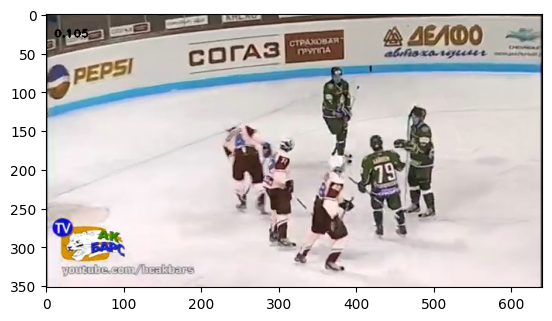

In [35]:
import matplotlib.pyplot as plt
plt.imshow(new_frames[1050])

In [29]:
new_frames[0].shape

(352, 640, 3)

In [32]:
writer = cv2.VideoWriter("output.avi",
cv2.VideoWriter_fourcc(*"MJPG"), 30,(640,352))

for frame in new_frames:
    writer.write(frame)

writer.release()

In [33]:
!ffmpeg -i output.avi -vf fps=30 -vcodec libx264 outputv2.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [1]:
import os
os.listdir('./')

['out1.mp4',
 'Хоккей_короткое.mp4',
 'README.md',
 'Untitled.ipynb',
 'glamurblond',
 '0.9546_mobilenet.pt',
 'output.avi',
 '.git',
 'quick_start_pytorch_images',
 'outputv2.mp4',
 'quick_start_pytorch.ipynb',
 '.ipynb_checkpoints']

In [ ]:
!rm -r /notebooks/glamurblond